In [2]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt 
from matplotlib import rcParams 

import pandas as pd
import multiprocessing as mp
import astropy.coordinates as coord
import numpy.ma as ma

In [3]:

pd.set_option('max_column',200)

In [4]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [5]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [6]:
ms=pd.read_csv('../Downloads/catalog/final/starall_sm.csv')

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 6.0000e+00,
        4.7000e+01, 6.9000e+01, 2.2000e+02, 4.4200e+02, 9.4600e+02,
        1.8460e+03, 2.9490e+03, 4.3040e+03, 5.3510e+03, 6.6080e+03,
        7.6230e+03, 9.0210e+03, 1.0172e+04, 1.1416e+04, 1.2798e+04,
        1.5036e+04, 1.7891e+04, 2.0089e+04, 2.6875e+04, 3.3555e+04,
        3.9218e+04, 4.1263e+04, 3.9351e+04, 3.4582e+04, 2.8288e+04,
        2.3256e+04, 1.8779e+04, 1.5428e+04, 1.3372e+04, 1.2226e+04,
        1.2080e+04, 1.2271e+04, 1.3525e+04, 1.5123e+04, 1.7095e+04,
        1.9237e+04, 1.9701e+04, 1.8271e+04]),
 array([17. , 17.3, 17.6, 17.9, 18.2, 18.5, 18.8, 19.1, 19.4, 19.7, 20. ,
        20.3, 20.6, 20.9, 21.2, 21.5, 21.8, 22.1, 22.4, 22.7, 23. , 23.3,
        23.6, 23.9, 24.2, 24.5, 24.8, 25.1, 25.4, 25.7, 26. , 26.3, 26.6,
        26.9, 27.2, 27.5, 27.8, 28.1, 28.4, 28.7, 29. , 29.3, 29.6, 29.9]),
 <a list of 43 Patch objects>)

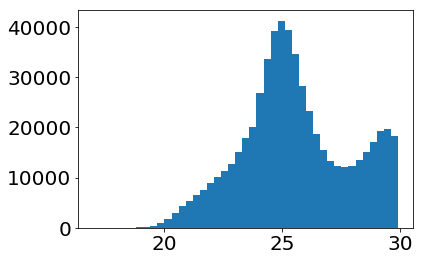

In [35]:
plt.hist(ms.psfmag_u,bins=np.arange(17,30,0.3))

In [12]:
imag=np.arange(17,25,0.1)
uerr=[]

for j in imag:
    t=ms[(ms.i_psfflux_mag>j)&(ms.i_psfflux_mag<j+0.1)]
    uerr.append(np.median(t.psfmagerr_u))

    
umag=np.arange(17,30,0.1)
uerr2=[]

for j in umag:
    t=ms[(ms.psfmag_u>j)&(ms.psfmag_u<j+0.1)]
    uerr2.append(np.median(t.psfmagerr_u))

In [20]:
umag=ms.psfmag_u
gmag=ms.psfMag_g
rmag=ms.psfMag_r
imag=ms.psfMag_i
uerr=ms.psfmagerr_u
gerr=ms.psfmagerr_g
rerr=ms.psfmagerr_r
ierr=ms.psfmagerr_i

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(umag, uerr, 17, 30, 40, 0)
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(gmag, gerr, 17, 30, 40, 0)
x1Bin3, n1Pts3, m1edianBin3, s1igGbin3 = fitMedians(rmag, rerr, 17, 30, 40, 0)
x1Bin4, n1Pts4, m1edianBin4, s1igGbin4 = fitMedians(imag, ierr, 17, 26, 40, 0)

Text(0.5, 0, '$\\rm{magnitude}_{\\rm{PSF}}$')

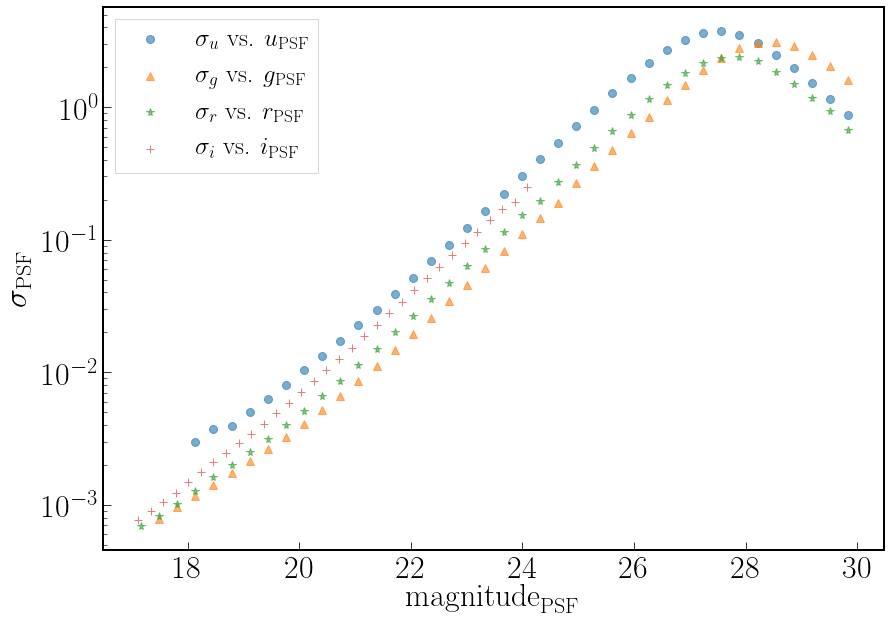

In [25]:
plt.figure(figsize=(14,10))
plt.plot(x1Bin1,m1edianBin1,'o',markersize=8,alpha=0.6,label=r'$\sigma_u$ vs. $u_{\rm{PSF}}$')
plt.plot(x1Bin2,m1edianBin2,'^',markersize=8,alpha=0.6,label=r'$\sigma_g$ vs. $g_{\rm{PSF}}$')
plt.plot(x1Bin3,m1edianBin3,'*',markersize=8,alpha=0.6,label=r'$\sigma_r$ vs. $r_{\rm{PSF}}$')
plt.plot(x1Bin4,m1edianBin4,'+',markersize=8,alpha=0.6,label=r'$\sigma_i$ vs. $i_{\rm{PSF}}$')
plt.legend()
plt.yscale('log')
plt.ylabel(r'$\sigma_{\rm{PSF}}$')
plt.xlabel(r'$\rm{magnitude}_{\rm{PSF}}$')

In [26]:
umag=ms.psfmag_u
gmag=ms.psfMag_g
rmag=ms.psfMag_r
imag=ms.psfMag_i
uerr=ms.psfmagerr_u
gerr=ms.psfmagerr_g
rerr=ms.psfmagerr_r
ierr=ms.psfmagerr_i

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(imag, uerr, 17, 25, 40, 0)
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(imag, gerr, 17, 25, 40, 0)
x1Bin3, n1Pts3, m1edianBin3, s1igGbin3 = fitMedians(imag, rerr, 17, 25, 40, 0)
x1Bin4, n1Pts4, m1edianBin4, s1igGbin4 = fitMedians(imag, ierr, 17, 25, 40, 0)

Text(0.5, 0, '$i_{\\rm{PSF,S82}}$')

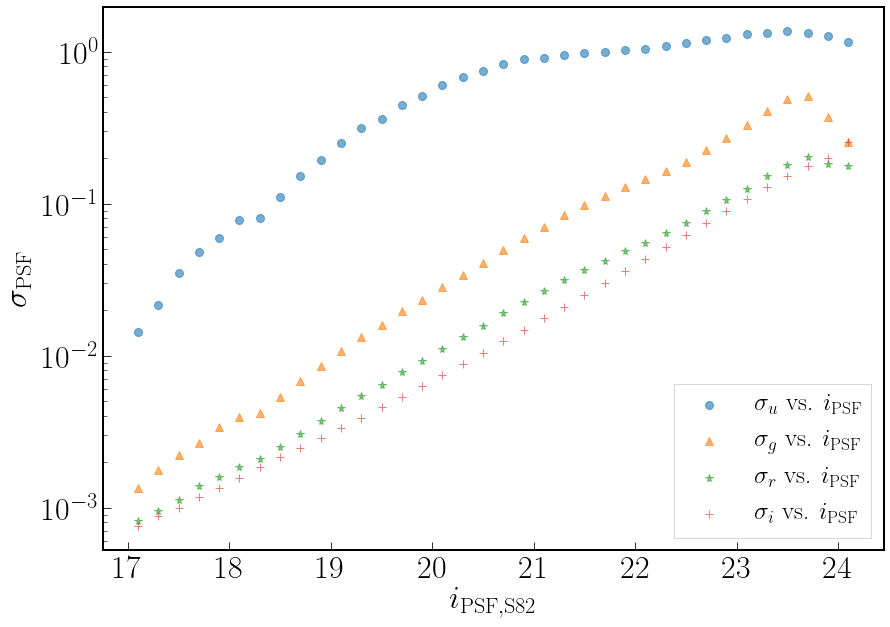

In [28]:
plt.figure(figsize=(14,10))
plt.plot(x1Bin1,m1edianBin1,'o',markersize=8,alpha=0.6,label=r'$\sigma_u$ vs. $i_{\rm{PSF}}$')
plt.plot(x1Bin2,m1edianBin2,'^',markersize=8,alpha=0.6,label=r'$\sigma_g$ vs. $i_{\rm{PSF}}$')
plt.plot(x1Bin3,m1edianBin3,'*',markersize=8,alpha=0.6,label=r'$\sigma_r$ vs. $i_{\rm{PSF}}$')
plt.plot(x1Bin4,m1edianBin4,'+',markersize=8,alpha=0.6,label=r'$\sigma_i$ vs. $i_{\rm{PSF}}$')
plt.legend()
plt.yscale('log')
plt.ylabel(r'$\sigma_{\rm{PSF}}$')
plt.xlabel(r'$i_{\rm{PSF,S82}}$')

In [7]:

gmag=ms.g_psfflux_mag
rmag=ms.r_psfflux_mag
imag=ms.i_psfflux_mag
gerr=ms.g_psfflux_magsigma
rerr=ms.r_psfflux_magsigma
ierr=ms.i_psfflux_magsigma

x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(gmag, gerr, 17, 30, 40, 0)
x1Bin3, n1Pts3, m1edianBin3, s1igGbin3 = fitMedians(rmag, rerr, 17, 30, 40, 0)
x1Bin4, n1Pts4, m1edianBin4, s1igGbin4 = fitMedians(imag, ierr, 17, 26, 40, 0)

Text(0.5, 0, '$\\rm{magnitude}_{\\rm{PSF}}$')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


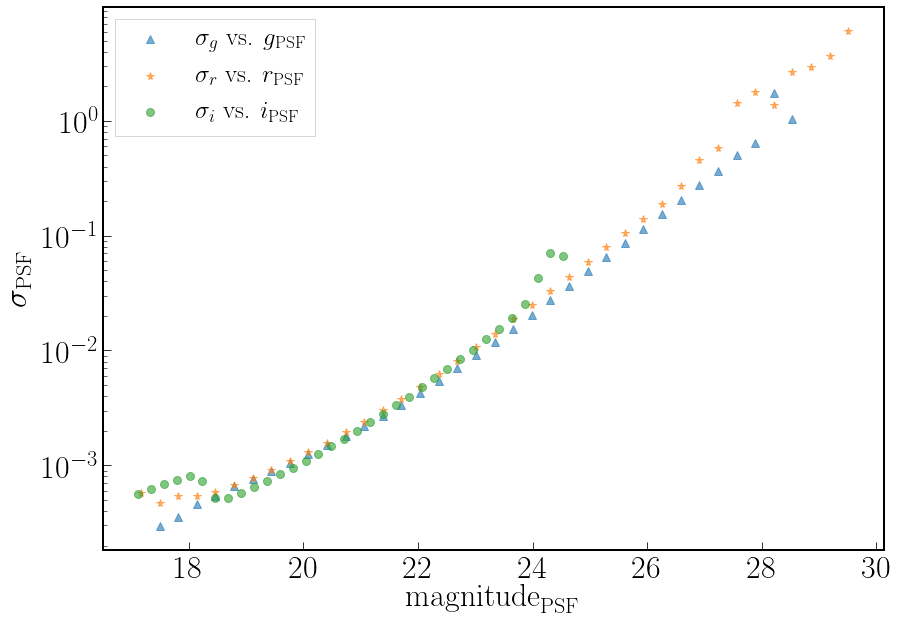

In [8]:
plt.figure(figsize=(14,10))
#plt.plot(x1Bin1,m1edianBin1,'o',markersize=8,alpha=0.6,label=r'$\sigma_u$ vs. $u_{\rm{PSF}}$')
plt.plot(x1Bin2,m1edianBin2,'^',markersize=8,alpha=0.6,label=r'$\sigma_g$ vs. $g_{\rm{PSF}}$')
plt.plot(x1Bin3,m1edianBin3,'*',markersize=8,alpha=0.6,label=r'$\sigma_r$ vs. $r_{\rm{PSF}}$')
plt.plot(x1Bin4,m1edianBin4,'o',markersize=8,alpha=0.6,label=r'$\sigma_i$ vs. $i_{\rm{PSF}}$')
plt.legend()
plt.yscale('log')
plt.ylabel(r'$\sigma_{\rm{PSF}}$')
plt.xlabel(r'$\rm{magnitude}_{\rm{PSF}}$')

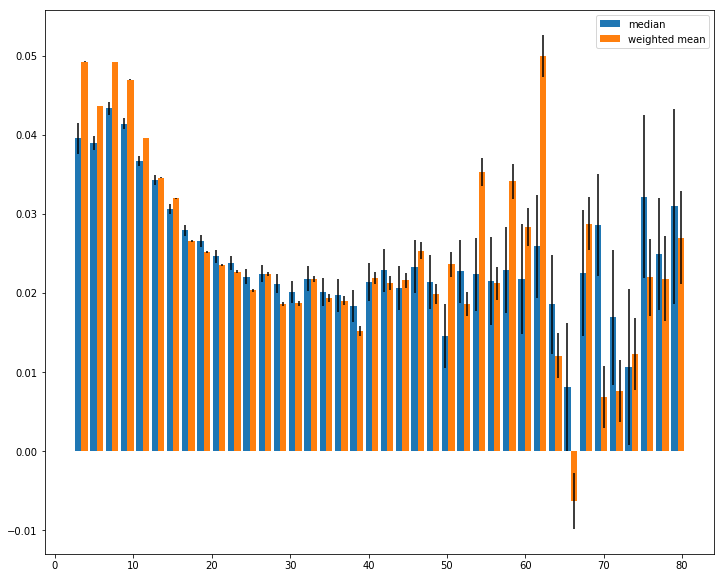

In [122]:
plt.figure(figsize=(12,10))
plt.bar(x1Bin,m1edianBin,yerr=s1igGbin,label='median')
plt.bar(x1Bin+0.8,wmean,yerr=werr,label='weighted mean')
plt.legend()

In [4]:
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin




In [4]:
def getMainSequenceAbsMag(gi,FeH): 
    """Get absolute magnitude for main sequence stars using eqs. 2, 5, and 7 from
       Ivezic et al. 2008 (ApJ, 684, 287)"""

    # valid for 0.2 < g-i < 4.0 
    Mr0 = -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    # offset for metallicity, valid for -2.5 < FeH < 0.2
    Mr = Mr0 + 4.50 - 1.11*FeH - 0.18*FeH**2
    return Mr

def getMainSequenceDistanceKpc(gi,FeH,r): 
    """Get stellar distance in kpc"""
    
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    # distance in kpc
    Dkpc = 0.01 * 10**(0.2*(r-Mr))
    return Dkpc

def getMainSequenceAppMagforDistanceKpc(gi,FeH,Dkpc): 
    """Get apparent mag array for g-i array, given FeH and Dkpc"""
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    return Mr + 5*np.log10(100*Dkpc)  

def getPhotomMetallicityBond2010(ug,gr):
    """Get stellar photometric metallicity from the SDSS u, g and r magnitudes
       using eq.A1 from Bond et al. 2010 (ApJ, 716, 1):
       [Fe/H]=A+Bx+Cy+Dxy+Ex2+Fy2+Gx2y+Hxy2+Ix3+Jy3
       with x = (u-g) and y = (g-r), and the best-fit coefficients 
       (A-J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20).
       This expression if valid only for g-r<0.6; for redder stars uses [Fe/H] = -0.6.
       Beyond the limits -2.5 and 0.5, use the limits. Add Gaussian noise with rms=0.1"""

    # aux variables
    x = ug
    y = gr
    xy = x*y
    x2 = x*x
    y2 = y*y
    x2y = x*x*y
    xy2 = x*y*y
    y3 = y*y*y

    A = -13.13  
    B =  14.09
    C =  28.04
    D =  -5.51
    E =  -5.90
    F = -58.68
    G =   9.14
    H = -20.61
    I =  58.20
    FeH = A + B*x + C*y + D*xy + E*x2 + F*y2 + G*x2y + H*xy2 + I*y3 
    # add Gaussian noise (rms=0.1 dex) 
    np.random.seed(666) 
    b = np.random.randn(FeH.shape[0])  # Gaussian
    FeH = FeH + 0.1*b
    FeH[gr>0.6] = -0.6
    FeH[FeH < -2.5] = -2.5
    FeH[FeH > 0.5] = 0.5
    return FeH    

# error for distance

In [21]:
def d(d1,d2):
    t=np.sqrt(d1**2+d2**2)
    return t

def dMr0(dgi,gi):
    t=(14.32 - 12.97*gi*2 + 6.127*gi**2*3 - 1.267*gi**3*4 + 0.0967*gi**4*5)*dgi
    return t

def dFeH(ug,gr,dug,dgr):
    x = ug
    y = gr
    dx = dug
    dy = dgr
    xy = x*y
    x2 = x*x
    y2 = y*y
    B =  14.09
    C =  28.04
    D =  -5.51
    E =  -5.90
    F = -58.68
    G =   9.14
    H = -20.61
    I =  58.20
    t=np.sqrt((B + D*y + 2*E*x + 2*G*xy + H*y2)**2*dx**2+(C + D*x + 2*F*y + G*x2 + 2*H*xy + 3*I*y2)**2*dy**2)
    return t

def dMr(dmr0,dfeh,feh):
    t=np.sqrt(dmr0**2 + (-1.11 - 2*0.18*feh)**2*dfeh**2)
    return t

def dKpc(dr,dmr,kpc):
    t=np.log(10)*kpc/5*np.sqrt(dr**2+dmr**2)

In [37]:
ms=ms[pd.notna(ms.g_psfflux_mag)]
ms=ms[pd.notna(ms.i_psfflux_mag)]
ms=ms[pd.notna(ms.r_psfflux_mag)]
ms=ms[pd.notna(ms.psfmag_u)]

In [38]:
def error(i):
    t=ms[(ms.i_psfflux_mag>i-0.2)&(ms.i_psfflux_mag<i+0.2)]
    r=t.r_psfflux_mag
    dr=ms.r_psfflux_magsigma
    gi=t.g_psfflux_mag-t.i_psfflux_mag
    ug=t.psfmag_u-t.g_psfflux_mag
    gr=t.g_psfflux_mag-t.r_psfflux_mag
    dgi=d(t.g_psfflux_magsigma,t.i_psfflux_magsigma)
    dug=d(t.psfmagerr_u,t.g_psfflux_magsigma)
    dgr=d(t.g_psfflux_magsigma,t.r_psfflux_magsigma)
    mr0= -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    dmr0=dMr0(dgi,gi)
    feh=getPhotomMetallicityBond2010(ug,gr)
    dfeh=dFeH(ug,gr,dug,dgr)
    mr=getMainSequenceAbsMag(gi,feh)
    dmr=dMr(dmr0,dfeh,feh)
    kpc=getMainSequenceDistanceKpc(gi,feh,r)
    dkpc=dKpc(dr,dmr,kpc)
    print(dkpc)
    return dkpc

In [39]:
a=error(17.5)

None


In [30]:
a